## Scenario 1: Bank notes dataset

**Note:** This notebook accompanies the thesis with the title: *Model monitoring from a business perspective \& ground truth dela*y by Bibian Bennink. This notebook makes use of code created by others, and this work is explicitly linked. In the thesis document all sources are properly cited too. 

###Introduction 
This notebook is used to compare Confidance Based Performance Estimation  [(CPBE)](https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html) created by NannyML and Continuous ReEvaluation [(CRE) ](https://link.springer.com/content/pdf/10.1007/s10618-019-00654-y.pdf?pdf=button) created by Grzenda, Gomes and Bifet on the first scenario: Banknotes dataset. 

The banknotes data set is obtained from the UCI Machine Learning Repository where it is called: [banknote authentication Data Set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). The data in this dataset is extracted from images taken from genuine and forged banknotes. 

In [1]:
#pip installs
!pip install nannyml
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
# imports

# NannyML for CBPE
import nannyml as nml
from IPython.display import display

# General libraries
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import datetime

# Classifier Library
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, mean_squared_error
from collections import Counter
from scipy import spatial
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

###Loading in data and gathering information about the data.

In [3]:
#Connect drive files to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reading in the banknote dataset and checking if it is read in correctly
data = pd.read_csv('/content/drive/MyDrive/Research project /data_banknote_authentication.txt', sep=",", header=None)
data.columns = ["variance", "skewness", "curtosis", "entropy","class"]
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
#Check the dataset values
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [6]:
#Check balance of the dataset
fraud = data['class'].value_counts()
print("Real %: ", fraud[1]/len(data)*100)
print("Fraud %:", fraud[0]/len(data)*100)

Real %:  44.460641399416915
Fraud %: 55.539358600583085


In [7]:
#splitting into X and y
X = data.loc[: ,data.columns != "class"]
y = data["class"]

#train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

In [8]:
# Get production data/ ground truth data ready and add ID column  
production_data = X_test.copy()
production_data['id'] = range(1, len(production_data) + 1)

ground_truth = X_test.copy()
ground_truth['class'] = y_test
ground_truth['id'] = range(1, len(ground_truth) + 1)

### Training the model

In [12]:
#training the Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("Train Score: ", rfc.score(X_train, y_train))
[(est.get_depth(), est.tree_.max_depth) for est in rfc.estimators_]

Train Score:  1.0


[(7, 7),
 (7, 7),
 (9, 9),
 (7, 7),
 (8, 8),
 (8, 8),
 (9, 9),
 (7, 7),
 (8, 8),
 (7, 7),
 (10, 10),
 (9, 9),
 (7, 7),
 (10, 10),
 (7, 7),
 (9, 9),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (6, 6),
 (6, 6),
 (7, 7),
 (6, 6),
 (8, 8),
 (7, 7),
 (8, 8),
 (8, 8),
 (8, 8),
 (7, 7),
 (9, 9),
 (10, 10),
 (7, 7),
 (6, 6),
 (7, 7),
 (7, 7),
 (9, 9),
 (8, 8),
 (10, 10),
 (10, 10),
 (6, 6),
 (8, 8),
 (8, 8),
 (9, 9),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (8, 8),
 (8, 8),
 (8, 8),
 (7, 7),
 (7, 7),
 (9, 9),
 (8, 8),
 (10, 10),
 (8, 8),
 (7, 7),
 (9, 9),
 (7, 7),
 (7, 7),
 (7, 7),
 (8, 8),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (8, 8),
 (9, 9),
 (8, 8),
 (7, 7),
 (8, 8),
 (7, 7),
 (7, 7),
 (6, 6),
 (9, 9),
 (7, 7),
 (9, 9),
 (7, 7),
 (6, 6),
 (8, 8),
 (7, 7),
 (8, 8),
 (7, 7),
 (9, 9),
 (10, 10),
 (9, 9),
 (7, 7),
 (8, 8),
 (7, 7),
 (9, 9),
 (9, 9),
 (9, 9),
 (7, 7),
 (8, 8),
 (8, 8),
 (9, 9),
 (7, 7)]

In [13]:
#training the Random Forest Classifier with a maximum depth of 3
rfc3 = RandomForestClassifier(max_depth = 3)
rfc3.fit(X_train, y_train)
print("Train Score: ", rfc3.score(X_train, y_train))

Train Score:  0.9611178614823815


In [14]:
#training the Random Forest Classifier with a maximum depth of 1
rfc1 = RandomForestClassifier(max_depth=1)
rfc1.fit(X_train, y_train)
print("Train Score: ", rfc1.score(X_train, y_train))

Train Score:  0.8869987849331713


### Functions needed for the algorithms to be tested.

In [15]:
# Calculate what the start and end time of the test will be based on the number
# of datapoints in the test dataset.
def running_time(n_datapoints):

  # one point every 10 minutes
  time_needed = (n_datapoints * 10)/60
  start_time = datetime.datetime.now() - datetime.timedelta(hours=time_needed)
  
  return start_time

In [16]:
# Get an array of 0 and 1, where 0 is sending a datapoint and 1 sending 
# the ground truth.

# send_gt: Every send_gt'th datapoint will be a ground truth 
# start_gt: The first ground truth will arrive from the start_gt'th datapoint
def get_send_distribution(send_gt,start_gt):
  
  distribution = [0]*start_gt
  datapoint_nr = start_gt

  for i in range(len(X_test)*2-start_gt):
    if i%send_gt == 0:
      distribution.append(1)
    elif datapoint_nr <= len(X_test)-1:
      distribution.append(0)
      datapoint_nr+=1
    else:
      distribution.append(1)

  return distribution

## CBPE

##### Functions

In [17]:
# Using the CBPE algorithm by NannyML according to their tutorial: 
#https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html
def use_CBPE(reference_df,analysis_df, k): 
  
  estimator = nml.CBPE(
      y_pred_proba='predict_proba',
      y_pred='y_hat',
      y_true='class',
      timestamp_column_name='timestamp',
      metrics=['roc_auc', 'f1', 'precision', 'recall', 'accuracy','specificity'],
      chunk_size=k,
      problem_type='classification_binary',
  )

  estimator.fit(reference_df)
  
  results = estimator.estimate(analysis_df)
  #display(results.filter(period='analysis').to_df())
  
  #return both the estimator itself as the df of the results
  return estimator, results.filter(period='analysis').to_df()


##### Transforming the Data

In [18]:
# Paremeters
REF_ANA_SPLIT = 50
CHUNK = 50

##### Testing *CBPE*

In [19]:
def run_CBPE(model, X_test, y_test, production_data, ground_truth, send_gt=20, start_gt=50):
  # Copy of the data for safekeeping
  CBPE_data = X_test.copy()
  CBPE_data['class'] = y_test

  # Two copies as from production_data rows will be dropped
  CBPE_production_data = production_data.copy() 
  CBPE_prod = CBPE_production_data.copy()

  CBPE_ground_truth = ground_truth.copy()
  CBPE_gt = CBPE_ground_truth.copy()

  # Get the distribution that determines which datapoint gets send
  CBPE_send_dist = get_send_distribution(send_gt = send_gt, start_gt = start_gt)

  # defining the start and end time. 
  start_time = running_time(len(X_test))
  elapsed = 0

  #Dataframes that will save the predictions and timestamps. 
  reference_predictions = pd.DataFrame(columns=['y_hat','predict_proba','timestamp' ,'id'])
  analysis_predictions = pd.DataFrame(columns=['y_hat','predict_proba','timestamp','id'])
  ground_truth_time = pd.DataFrame(columns=['timestamp','id'])

  for idx, i in enumerate(CBPE_send_dist):
    # Artificial time of the datapoint
    date_time = start_time + datetime.timedelta(minutes=elapsed)
    elapsed +=5
    # if 0, then a datapoint arrived
  
    if i == 0:
      # get datapoint
      x = CBPE_production_data.head(1)
      CBPE_production_data = CBPE_production_data.tail(-1)
      x_id = str(x['id'].iloc[0])
      datapoint = x.drop('id',axis=1)
    
      # get prediction
      y_hat = model.predict(datapoint)
      probability = model.predict_proba(datapoint)

      new_row= pd.DataFrame({'y_hat': y_hat,'predict_proba': probability[0][1], 'timestamp': date_time,'id': x_id})
      if idx < REF_ANA_SPLIT:
        reference_predictions = pd.concat([new_row, reference_predictions.loc[:]]).reset_index(drop=True)
      else: analysis_predictions = pd.concat([new_row, analysis_predictions.loc[:]]).reset_index(drop=True)
  
    # if 1, then the ground truth arrived
    if i == 1:
      # get ground truth
      y = CBPE_ground_truth.head(1)
      CBPE_ground_truth = CBPE_ground_truth.tail(-1)
      y_id = str(y['id'].iloc[0])

      new_row= pd.DataFrame.from_records([{'timestamp': date_time, 'id': y_id}])
      ground_truth_time = pd.concat([new_row, ground_truth_time.loc[:]]).reset_index(drop=True)
 
  # Creating the reference dataset for the CBPE algorithm
  reference_predictions['id']= reference_predictions['id'].astype(int)
  reference_df = pd.merge(reference_predictions, CBPE_prod , on = 'id', how="inner")
  f = CBPE_gt[['id','class']]
  reference_df = pd.merge(reference_df, f , on = 'id', how="inner")
  reference_df['y_hat'] = reference_df['y_hat'].astype(int)

  # Creating the analysis dataset for the CBPE algorithm
  analysis_predictions['id']= analysis_predictions['id'].astype(int)
  analysis_df = pd.merge(analysis_predictions, CBPE_prod , on = 'id', how="inner")
  analysis_df['y_hat'] = analysis_df['y_hat'].astype(int)

  # Run the CBPE algorithm and check initial results
  cbpe, CBPE_results = use_CBPE(reference_df, analysis_df, CHUNK)
  return cbpe, CBPE_results,analysis_df, reference_df, CBPE_gt

##### Evaluation of CBPE

In [20]:
# Function to get the scores
def get_scores(actual, predictions):
  accuracy= accuracy_score(actual, predictions)
  f1= f1_score(actual, predictions)
  precision= precision_score(actual, predictions)
  roc_auc= roc_auc_score(actual, predictions)
  recall= recall_score(actual, predictions)
  # specificty is recall of negative class
  specificity= recall_score(actual, predictions, pos_label=0)
  return accuracy, f1, precision, roc_auc, recall, specificity

In [21]:
# This code is adapted from the nannyML tutorial code:
#https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html
def get_roc_auc_plot(CBPE_gt,CBPE_results,analysis_df,reference_df):

  # add ground truth to analysis
  analysis_targets = CBPE_gt[['id','class']]
  analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
  df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)

  # calculate actual ROC AUC
  target_col = 'class'
  pred_score_col = 'predict_proba'
  actual_performance = []
  for idx in CBPE_results.index:
    start_date, end_date = CBPE_results.loc[idx, ('chunk', 'start_date')], CBPE_results.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    CBPE_results.loc[idx, ('roc_auc', 'realized')] = actual_perf
  # plot
  first_analysis = CBPE_results[('chunk', 'key')].values[8]
  plt.figure(figsize=(10,5))
  plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('roc_auc', 'value')], label='estimated ROC AUC')
  plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('roc_auc', 'realized')], label='actual ROC AUC')
  plt.xticks(rotation=90)
  plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
  plt.ylabel('ROC AUC')
  plt.legend()
  plt.show()
  print("MSE:", mean_squared_error(CBPE_results[('roc_auc', 'value')], CBPE_results[('roc_auc', 'realized')]))
  print("Pearson r:", pearsonr(CBPE_results[('roc_auc', 'value')], CBPE_results[('roc_auc', 'realized')]))

In [22]:
# This code is adapted from the nannyML tutorial code:
#https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html
def get_accuracy_plot(CBPE_gt,CBPE_results,analysis_df,reference_df):

  # add ground truth to analysis
  analysis_targets = CBPE_gt[['id','class']]
  analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
  df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)

  # calculate actual ROC AUC
  target_col = 'class'
  pred_score_col = 'predict_proba'
  actual_performance = []
  for idx in CBPE_results.index:
    start_date, end_date = CBPE_results.loc[idx, ('chunk', 'start_date')], CBPE_results.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = accuracy_score(sub[target_col], round(sub[pred_score_col]))
    CBPE_results.loc[idx, ('accuracy', 'realized')] = actual_perf
  # plot
  first_analysis = CBPE_results[('chunk', 'key')].values[8]
  plt.figure(figsize=(10,5))
  plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('accuracy', 'value')], label='estimated accuracy')
  plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('accuracy', 'realized')], label='actual accuracy')
  plt.xticks(rotation=90)
  plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  print("MSE:", mean_squared_error(CBPE_results[('accuracy', 'value')], CBPE_results[('accuracy', 'realized')]))
  print("Pearson r:",pearsonr(CBPE_results[('accuracy', 'value')], CBPE_results[('accuracy', 'realized')]))

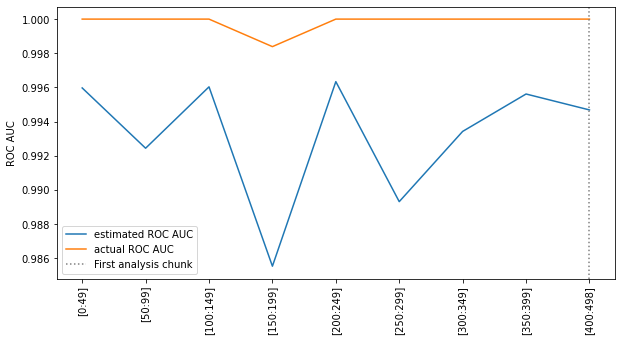

MSE: 5.244777895264407e-05
Pearson r: (0.7884953055712084, 0.011569288762995542)


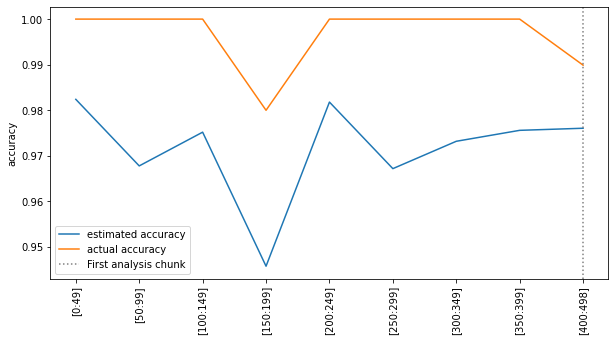

MSE: 0.0006714956519176033
Pearson r: (0.7577357461372595, 0.018012459679623994)


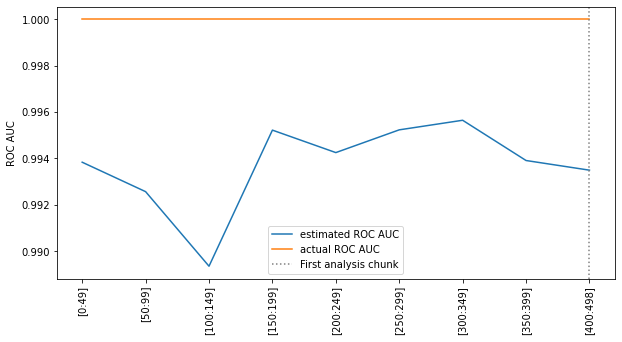

MSE: 4.2612520247135544e-05
Pearson r: (nan, nan)


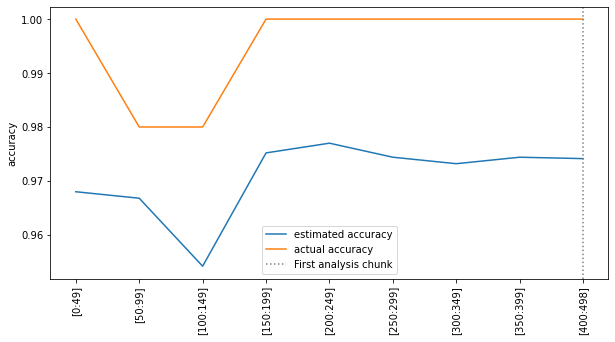

MSE: 0.0006339496069562053
Pearson r: (0.827052781308524, 0.005954698131125627)


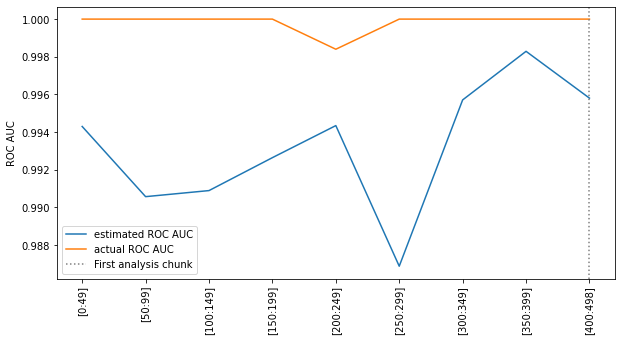

MSE: 5.399246288536813e-05
Pearson r: (-0.1176239553394956, 0.7631239894304725)


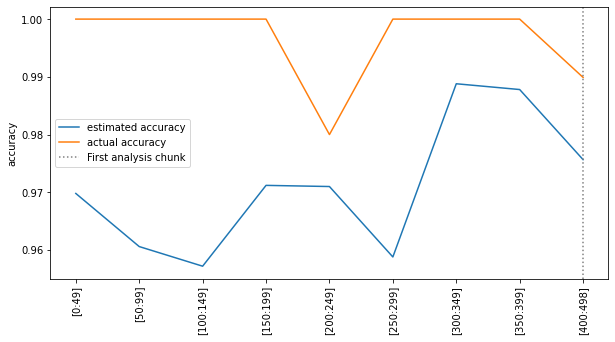

MSE: 0.000820138516477911
Pearson r: (-0.0623201928335734, 0.8734525270054947)


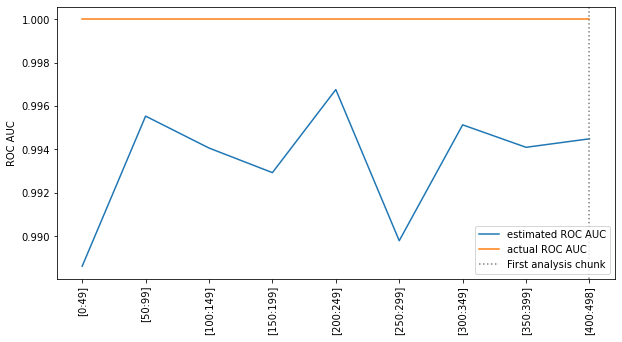

MSE: 4.867519414275705e-05
Pearson r: (nan, nan)


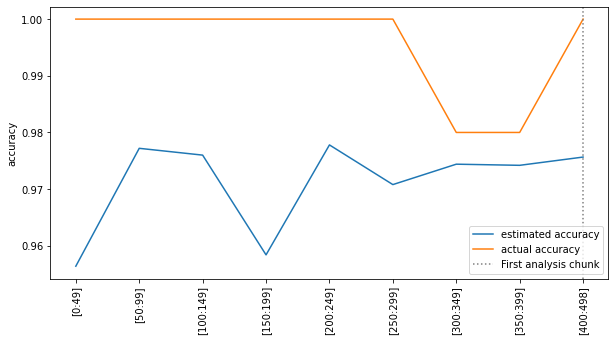

MSE: 0.0007478269772925663
Pearson r: (-0.21656844711641543, 0.5756923341988377)


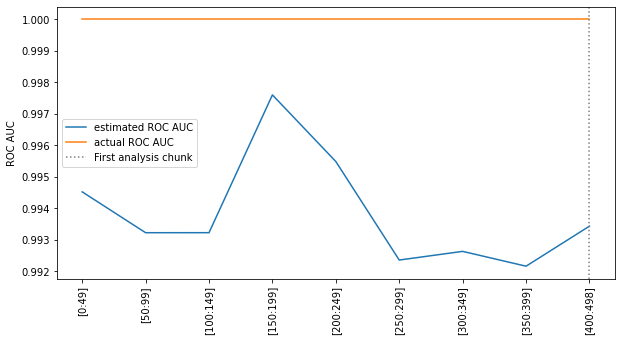

MSE: 4.064851810882733e-05
Pearson r: (nan, nan)


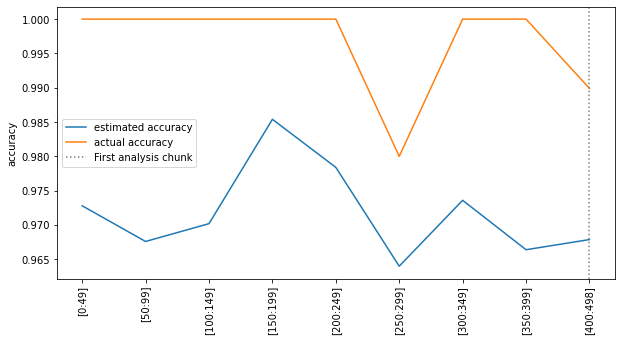

MSE: 0.0006582410330011686
Pearson r: (0.5164902984802263, 0.15455547986489418)


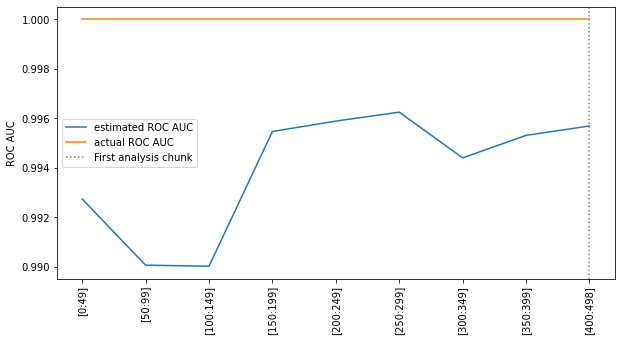

MSE: 4.1713526878562947e-05
Pearson r: (nan, nan)


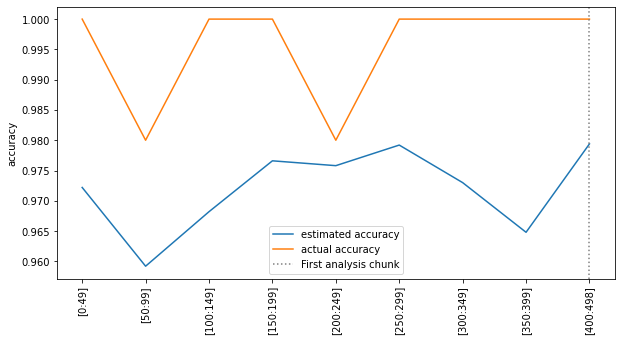

MSE: 0.0006230233037445166
Pearson r: (0.3771394491414482, 0.3170349218811114)


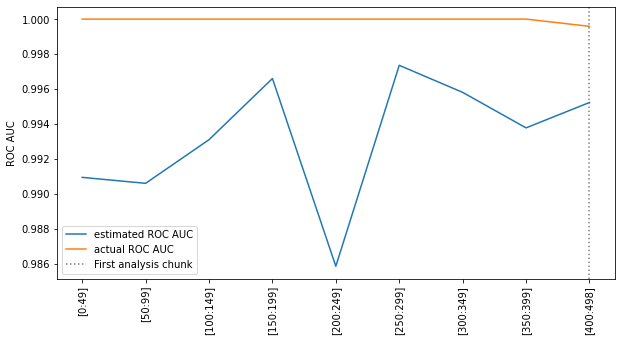

MSE: 5.696528898292331e-05
Pearson r: (-0.20379385574599548, 0.5989362079649887)


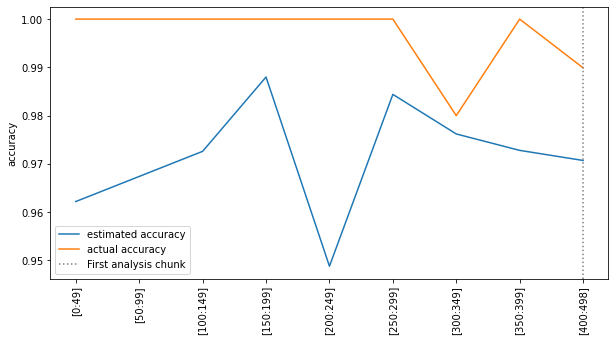

MSE: 0.0008193077513632404
Pearson r: (-0.1324307327202917, 0.734126169099804)


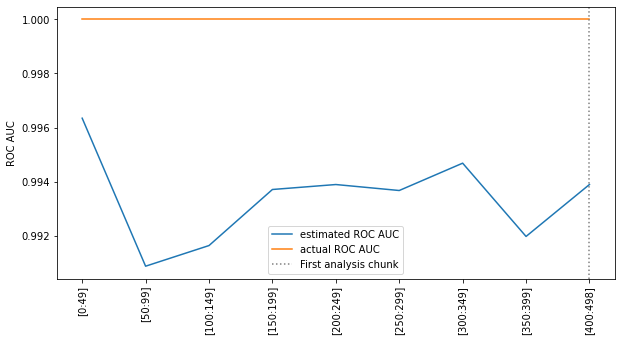

MSE: 4.5849593906486965e-05
Pearson r: (nan, nan)


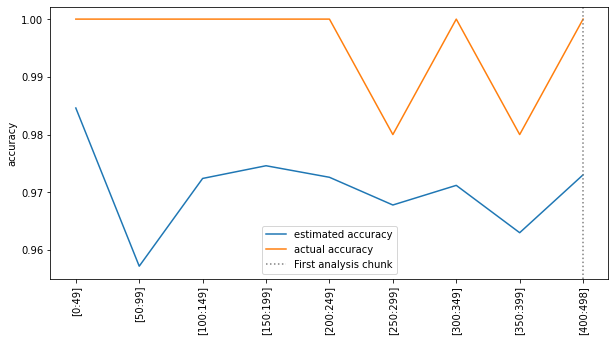

MSE: 0.0006912582838485884
Pearson r: (0.3928671289859905, 0.2955817655008034)


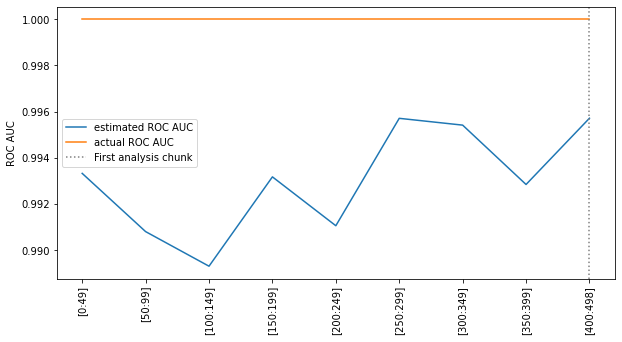

MSE: 5.327586320626029e-05
Pearson r: (nan, nan)


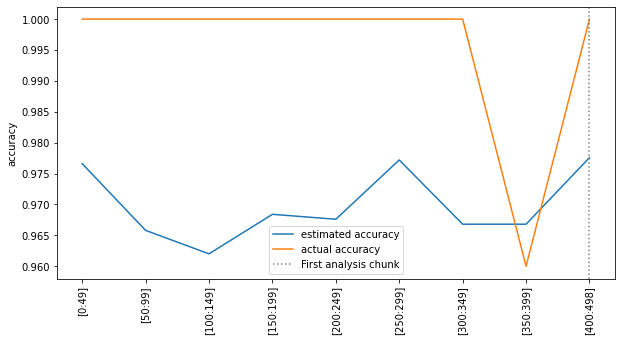

MSE: 0.0008200762942556891
Pearson r: (0.20036838427351758, 0.6052237483039573)


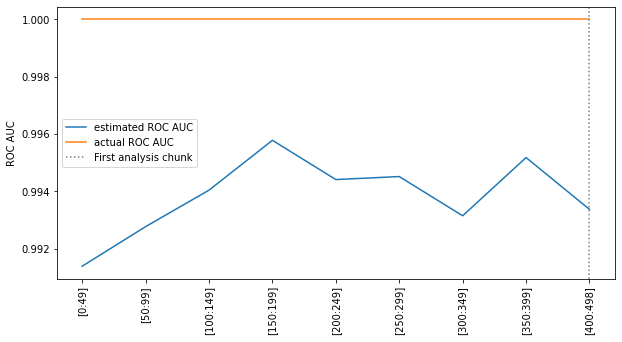

MSE: 3.9407027198584473e-05
Pearson r: (-0.1500452846447193, 0.7000070813616033)


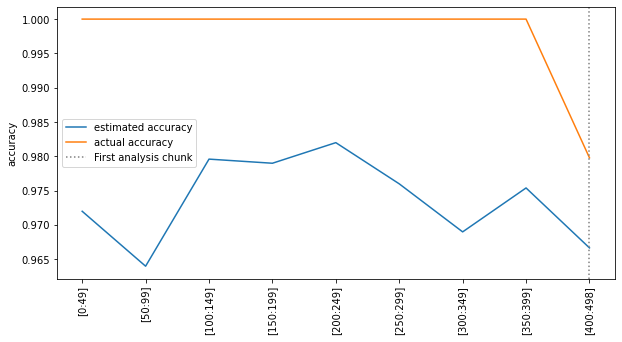

MSE: 0.0006195279316169541
Pearson r: (0.4271922058101182, 0.2514514292311229)
accuracy:  0.9963570127504553 - Prediction accuracy: 0.9714529741863076
f1:  0.9959016393442625 - Prediction  f1: 0.967357236794736
precision:  0.9918367346938777 - Prediction  precision: 0.9664292161845204
recall:  1.0 - Prediction  recall: 0.9685376477283445
specificity:  0.9934640522875817 - Prediction  specificity: 0.9719321252061229
roc_auc:  0.9967320261437909 - Prediction  roc_auc: 0.9935113508293506


In [28]:
#Get results in 10 fold - depth = none
CBPE_accuracy_all, CBPE_f1_all, CBPE_precision_all, CBPE_roc_auc_all, CBPE_recall_all, CBPE_specificity_all = ([] for i in range(6))
CBPE_pred_accuracy_all, CBPE_pred_f1_all, CBPE_pred_precision_all, CBPE_pred_roc_auc_all, CBPE_pred_recall_all, CBPE_pred_specificity_all = ([] for i in range(6))

for i in range(10):
  #run the CRE algorithm
  idx = np.random.permutation(production_data.index)
  cbpe, CBPE_results,analysis_df, reference_df, CBPE_gt = run_CBPE(rfc, X_test, y_test, production_data.reindex(idx), ground_truth.reindex(idx), send_gt=20, start_gt=50)
  
  #create plots
  get_roc_auc_plot(CBPE_gt,CBPE_results,analysis_df,reference_df)
  get_accuracy_plot(CBPE_gt,CBPE_results,analysis_df,reference_df)

  # Actual metrics
  analysis_targets = CBPE_gt[['id','class']]
  analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
  df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)

  gr = df_all['class'].to_numpy()
  CBPE_predictions = df_all['y_hat'].to_numpy().astype(int)
  CBPE_accuracy, CBPE_f1, CBPE_precision, CBPE_roc_auc, CBPE_recall, CBPE_specificity = get_scores(gr, CBPE_predictions)
  CBPE_accuracy_all.append(CBPE_accuracy)
  CBPE_f1_all.append(CBPE_f1)
  CBPE_precision_all.append(CBPE_precision)
  CBPE_roc_auc_all.append(CBPE_roc_auc)
  CBPE_recall_all.append(CBPE_recall)
  CBPE_specificity_all.append(CBPE_specificity)

  #CBPE metrics
  CBPE_pred_accuracy= CBPE_results['accuracy']['value']
  CBPE_pred_f1= CBPE_results['f1']['value']
  CBPE_pred_precision= CBPE_results['precision']['value']
  CBPE_pred_roc_auc= CBPE_results['roc_auc']['value']
  CBPE_pred_recall= CBPE_results['recall']['value']
  CBPE_pred_specificity= CBPE_results['specificity']['value']

  CBPE_pred_accuracy_all.append(np.mean(CBPE_pred_accuracy))
  CBPE_pred_f1_all.append(np.mean(CBPE_pred_f1))
  CBPE_pred_precision_all.append(np.mean(CBPE_pred_precision))
  CBPE_pred_roc_auc_all.append(np.mean(CBPE_pred_roc_auc))
  CBPE_pred_recall_all.append(np.mean(CBPE_pred_recall))
  CBPE_pred_specificity_all.append(np.mean(CBPE_pred_specificity))

# print results
print("accuracy: ", np.mean(CBPE_accuracy_all), "- Prediction accuracy:", np.mean(CBPE_pred_accuracy_all))
print("f1: ", np.mean(CBPE_f1_all), "- Prediction  f1:", np.mean(CBPE_pred_f1_all))
print("precision: ", np.mean(CBPE_precision_all), "- Prediction  precision:", np.mean(CBPE_pred_precision_all))
print("recall: ", np.mean(CBPE_recall_all), "- Prediction  recall:", np.mean(CBPE_pred_recall_all))
print("specificity: ", np.mean(CBPE_specificity_all), "- Prediction  specificity:", np.mean(CBPE_pred_specificity_all))
print("roc_auc: ", np.mean(CBPE_roc_auc_all), "- Prediction  roc_auc:", np.mean(CBPE_pred_roc_auc_all))


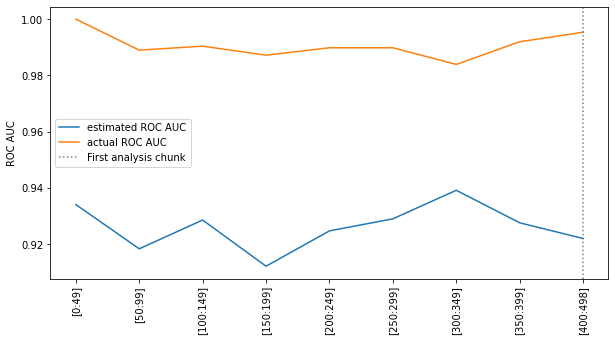

MSE: 0.0042476574874227525
Pearson r: (0.09491179630679317, 0.8080928733232378)


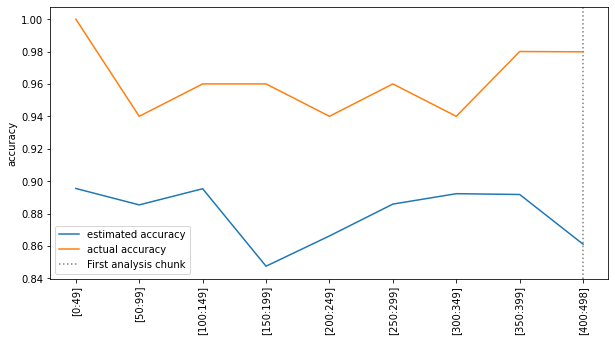

MSE: 0.007319326346319752
Pearson r: (0.13708007674993947, 0.7250787899513256)


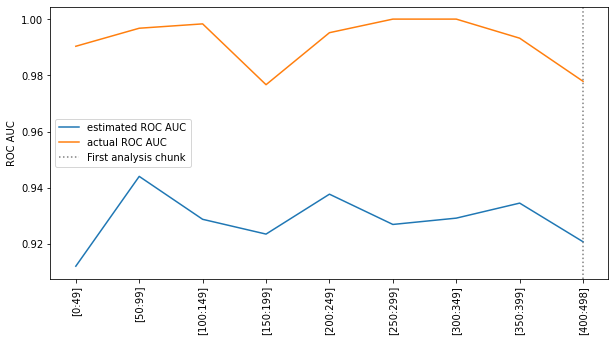

MSE: 0.004100074234226552
Pearson r: (0.46888945460193476, 0.2029439839370561)


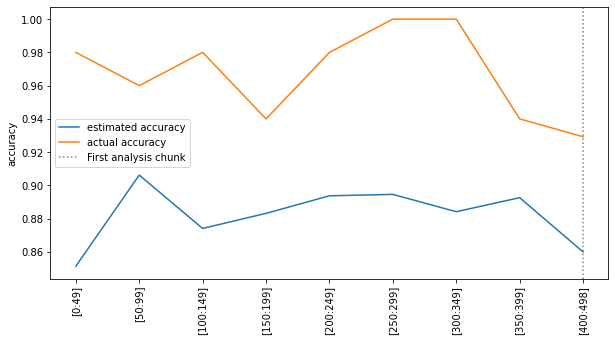

MSE: 0.008094076343850896
Pearson r: (0.12844752127055148, 0.7418999090003573)


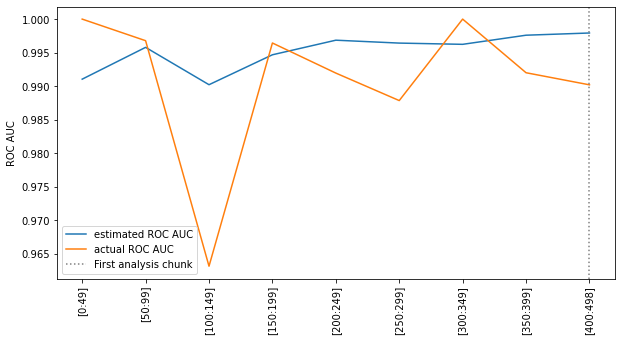

MSE: 0.00011334813040543026
Pearson r: (0.4385602331403193, 0.237665783647821)


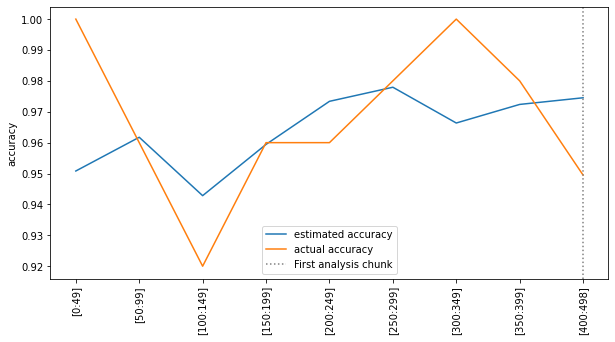

MSE: 0.0005492570122517643
Pearson r: (0.30099996299341314, 0.43123742624349803)


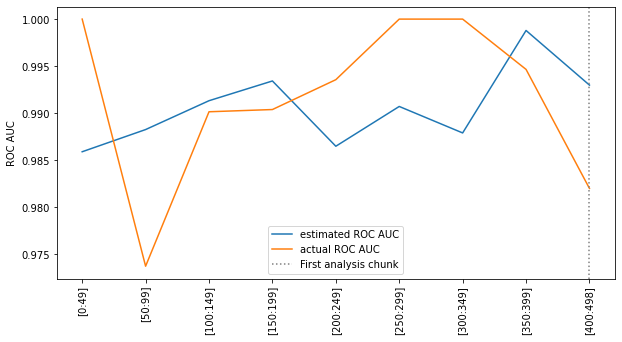

MSE: 9.346926615357948e-05
Pearson r: (-0.1020830826655528, 0.7938355617904698)


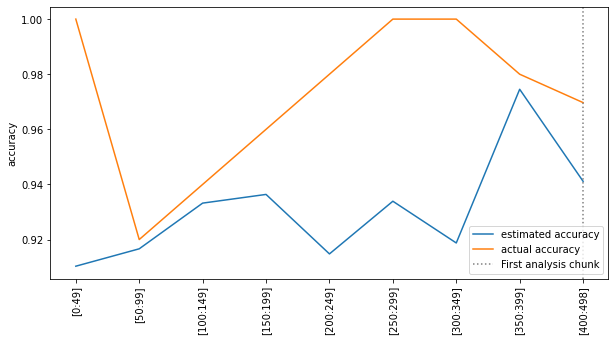

MSE: 0.0027469998225305233
Pearson r: (-0.007622302660767281, 0.98447272431777)


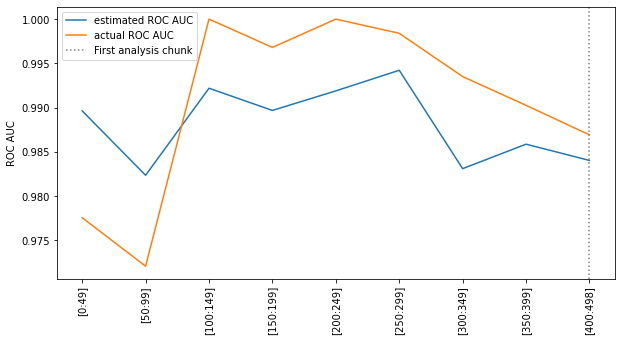

MSE: 6.464082269600213e-05
Pearson r: (0.6226554311419105, 0.0732950245537722)


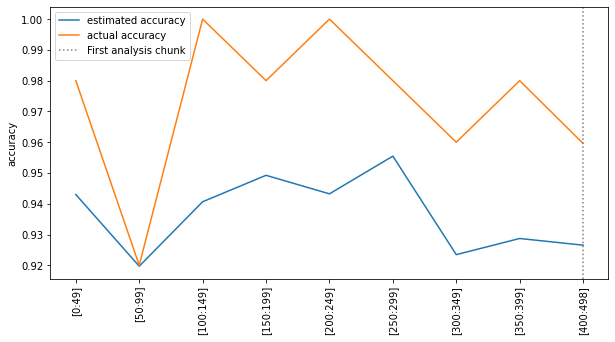

MSE: 0.0016355018253472059
Pearson r: (0.695990814164394, 0.03730761161599773)


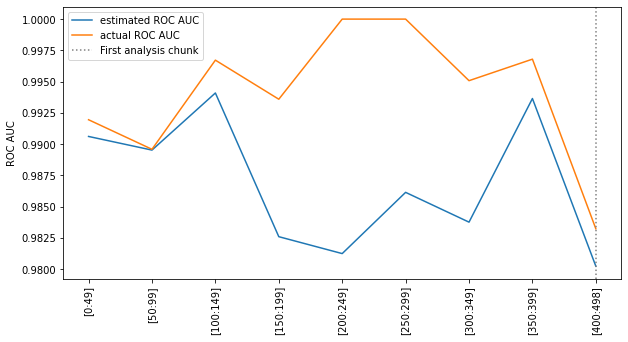

MSE: 9.12043344856089e-05
Pearson r: (0.22562998180433522, 0.559406575859068)


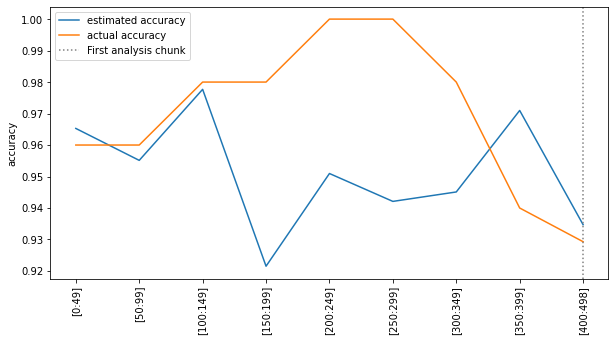

MSE: 0.0012714864232604474
Pearson r: (-0.13431449013049496, 0.7304570012871121)


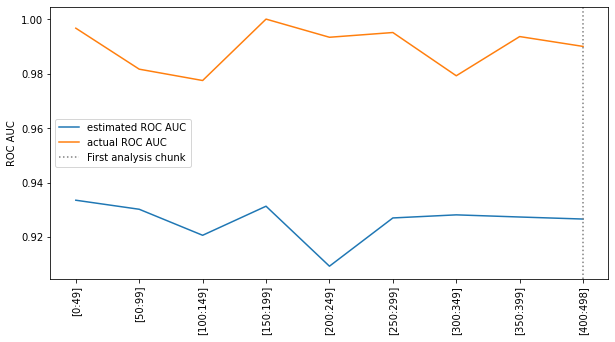

MSE: 0.00414367605292181
Pearson r: (0.14022709716203643, 0.7189714447021823)


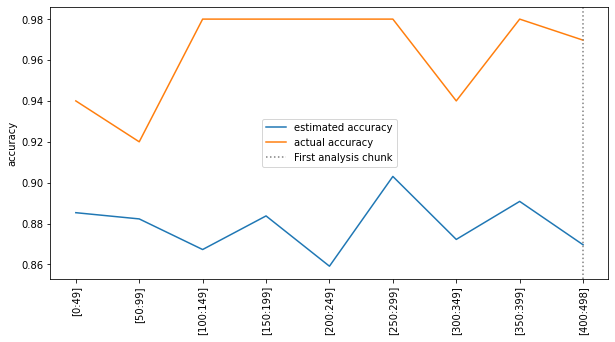

MSE: 0.007715115162219227
Pearson r: (-0.015852883158623366, 0.967711534391407)


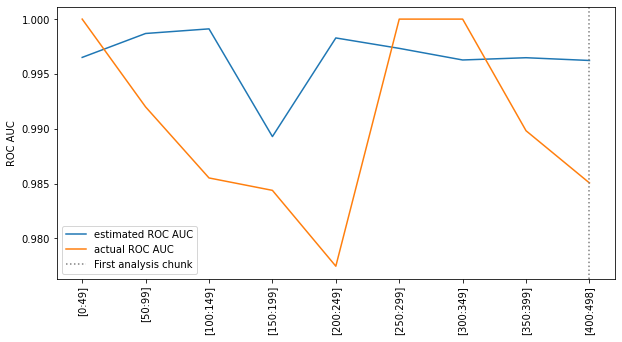

MSE: 9.89150441850778e-05
Pearson r: (0.096979344424912, 0.8039771681399486)


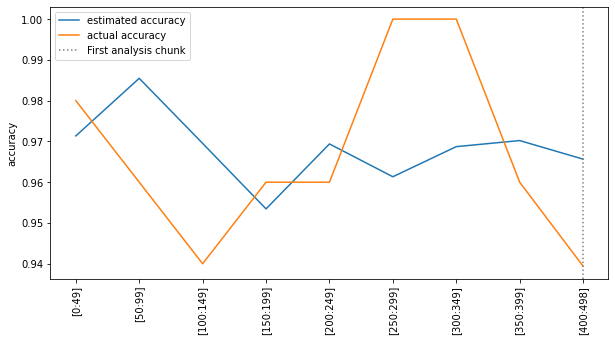

MSE: 0.000554818095516873
Pearson r: (-0.11262694500214526, 0.7729698058093045)


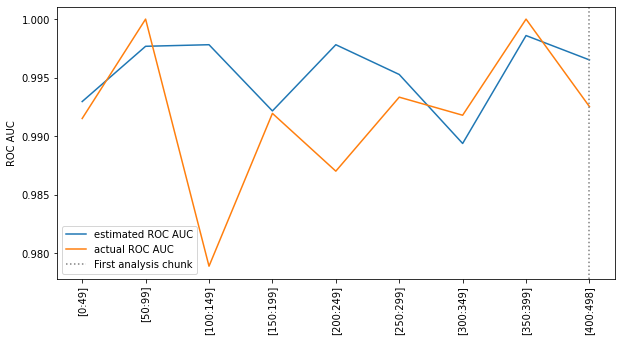

MSE: 5.660505571477083e-05
Pearson r: (0.0192346503315115, 0.9608275710670131)


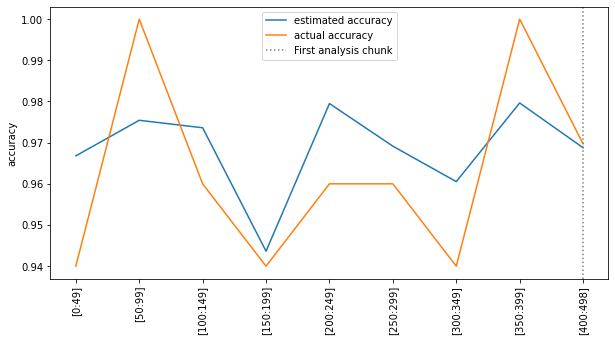

MSE: 0.00031340284457648005
Pearson r: (0.6731701516879952, 0.04687856272492276)


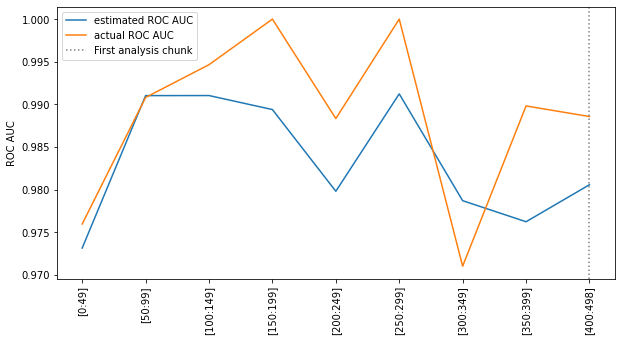

MSE: 6.5668846506515e-05
Pearson r: (0.7528577319072085, 0.01921407063723927)


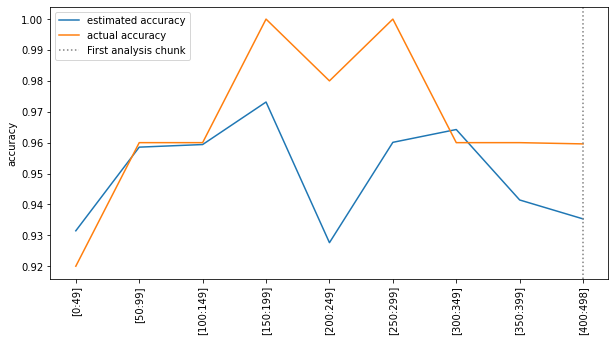

MSE: 0.0006825713056860242
Pearson r: (0.5061090110715505, 0.16446985176061504)
ccuracy:  0.9653916211293261 - Prediction accuracy: 0.9312289091583097
f1:  0.9609856262833676 - Prediction  f1: 0.9211226638148471
precision:  0.9590163934426229 - Prediction  precision: 0.9274444546849938
recall:  0.962962962962963 - Prediction  recall: 0.917182479717859
specificity:  0.9673202614379084 - Prediction  specificity: 0.9415625928408009
roc_auc:  0.9651416122004356 - Prediction  roc_auc: 0.971690637369335


In [29]:
#Get results in 10 fold - depth = 3
CBPE_accuracy_all3, CBPE_f1_all3, CBPE_precision_all3, CBPE_roc_auc_all3, CBPE_recall_all3, CBPE_specificity_all3 = ([] for i in range(6))
CBPE_pred_accuracy_all3, CBPE_pred_f1_all3, CBPE_pred_precision_all3, CBPE_pred_roc_auc_all3, CBPE_pred_recall_all3, CBPE_pred_specificity_all3 = ([] for i in range(6))

for i in range(10):
  #run the CRE algorithm
  idx = np.random.permutation(production_data.index)
  cbpe, CBPE_results,analysis_df, reference_df, CBPE_gt = run_CBPE(rfc3, X_test, y_test, production_data.reindex(idx), ground_truth.reindex(idx), send_gt=20, start_gt=50)
  
  #create plots
  get_roc_auc_plot(CBPE_gt,CBPE_results,analysis_df,reference_df)
  get_accuracy_plot(CBPE_gt,CBPE_results,analysis_df,reference_df)

  # Actual metrics
  analysis_targets = CBPE_gt[['id','class']]
  analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
  df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)

  gr = df_all['class'].to_numpy()
  CBPE_predictions = df_all['y_hat'].to_numpy().astype(int)
  CBPE_accuracy, CBPE_f1, CBPE_precision, CBPE_roc_auc, CBPE_recall, CBPE_specificity = get_scores(gr, CBPE_predictions)
  CBPE_accuracy_all3.append(CBPE_accuracy)
  CBPE_f1_all3.append(CBPE_f1)
  CBPE_precision_all3.append(CBPE_precision)
  CBPE_roc_auc_all3.append(CBPE_roc_auc)
  CBPE_recall_all3.append(CBPE_recall)
  CBPE_specificity_all3.append(CBPE_specificity)

  #CBPE metrics
  CBPE_pred_accuracy= CBPE_results['accuracy']['value']
  CBPE_pred_f1= CBPE_results['f1']['value']
  CBPE_pred_precision= CBPE_results['precision']['value']
  CBPE_pred_roc_auc= CBPE_results['roc_auc']['value']
  CBPE_pred_recall= CBPE_results['recall']['value']
  CBPE_pred_specificity= CBPE_results['specificity']['value']

  CBPE_pred_accuracy_all3.append(np.mean(CBPE_pred_accuracy))
  CBPE_pred_f1_all3.append(np.mean(CBPE_pred_f1))
  CBPE_pred_precision_all3.append(np.mean(CBPE_pred_precision))
  CBPE_pred_roc_auc_all3.append(np.mean(CBPE_pred_roc_auc))
  CBPE_pred_recall_all3.append(np.mean(CBPE_pred_recall))
  CBPE_pred_specificity_all3.append(np.mean(CBPE_pred_specificity))

# print results
print("ccuracy: ", np.mean(CBPE_accuracy_all3), "- Prediction accuracy:", np.mean(CBPE_pred_accuracy_all3))
print("f1: ", np.mean(CBPE_f1_all3), "- Prediction  f1:", np.mean(CBPE_pred_f1_all3))
print("precision: ", np.mean(CBPE_precision_all3), "- Prediction  precision:", np.mean(CBPE_pred_precision_all3))
print("recall: ", np.mean(CBPE_recall_all3), "- Prediction  recall:", np.mean(CBPE_pred_recall_all3))
print("specificity: ", np.mean(CBPE_specificity_all3), "- Prediction  specificity:", np.mean(CBPE_pred_specificity_all3))
print("roc_auc: ", np.mean(CBPE_roc_auc_all3), "- Prediction  roc_auc:", np.mean(CBPE_pred_roc_auc_all3))


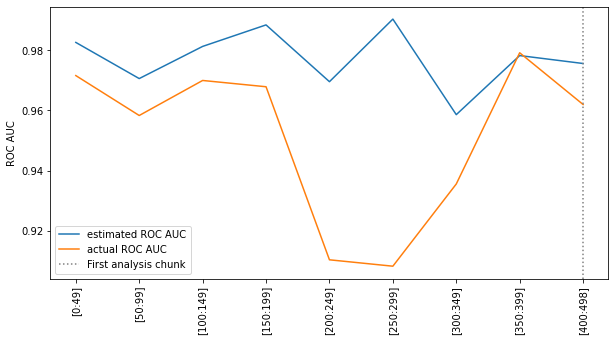

MSE: 0.0013082217314508448
Pearson r: (0.17581768906589398, 0.6509257660187115)


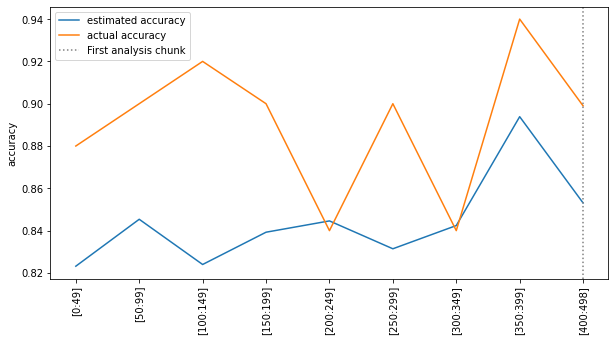

MSE: 0.0031207624577229342
Pearson r: (0.36736942759981395, 0.3307426717963092)


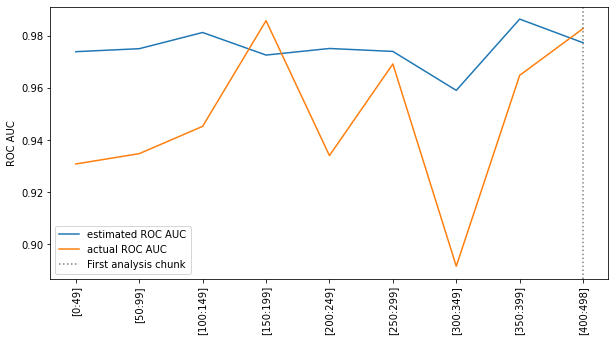

MSE: 0.001297212178244528
Pearson r: (0.5968103619266779, 0.08976799019429944)


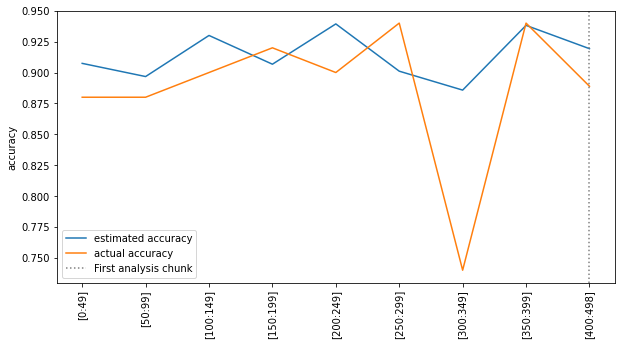

MSE: 0.0030385760416894183
Pearson r: (0.5749650682109371, 0.10532412532957512)


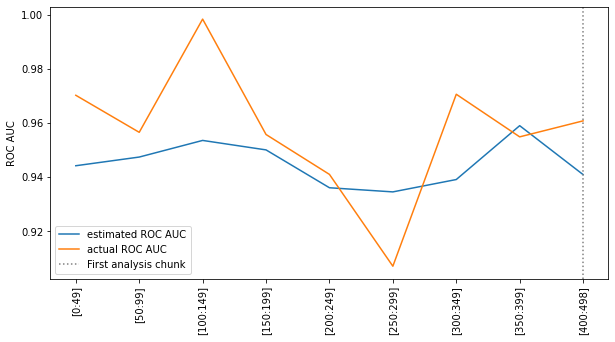

MSE: 0.0005539814291041687
Pearson r: (0.5408086611357016, 0.13272283546222902)


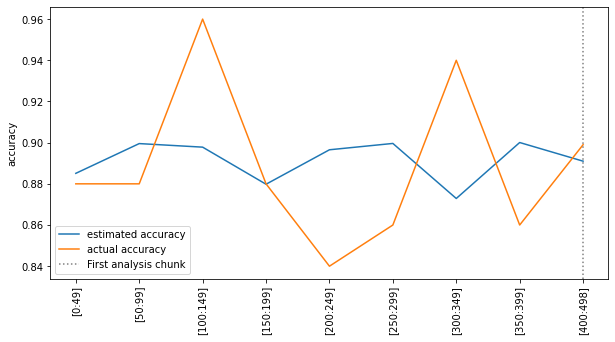

MSE: 0.001690451966496455
Pearson r: (-0.37041798823793826, 0.32643438090053417)


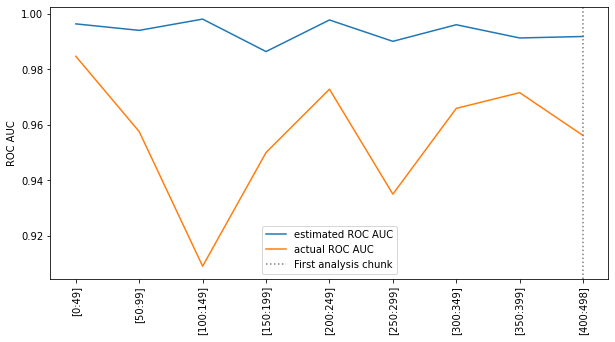

MSE: 0.0018843612465118012
Pearson r: (0.06259358661028279, 0.8729009894009515)


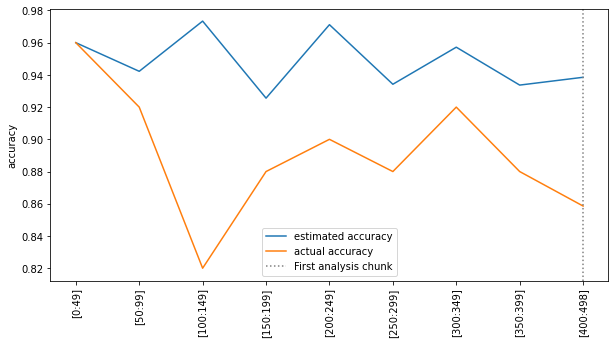

MSE: 0.00497302348323846
Pearson r: (0.035033582641712274, 0.9287031277677894)


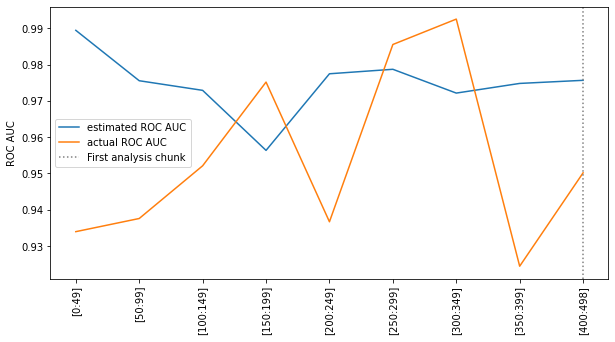

MSE: 0.001177764241720428
Pearson r: (-0.4296431129164631, 0.2484440252611547)


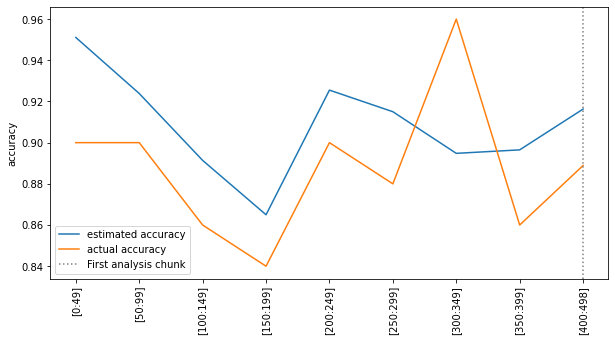

MSE: 0.0014444873472861917
Pearson r: (0.4029358922726342, 0.2822507951155839)


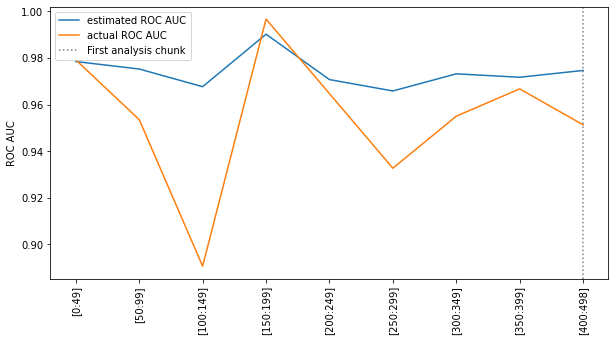

MSE: 0.0009425862566515249
Pearson r: (0.7649298768970006, 0.01633315799820559)


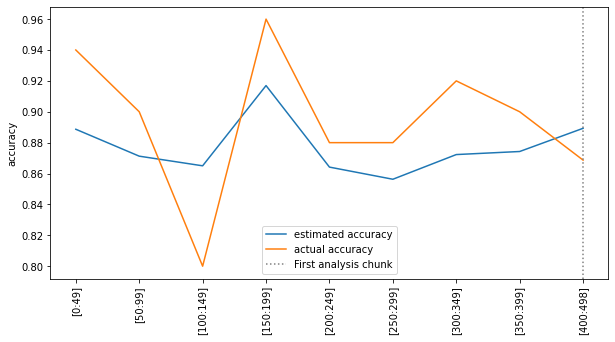

MSE: 0.0015238393941074202
Pearson r: (0.6331666509432825, 0.06718007931976908)


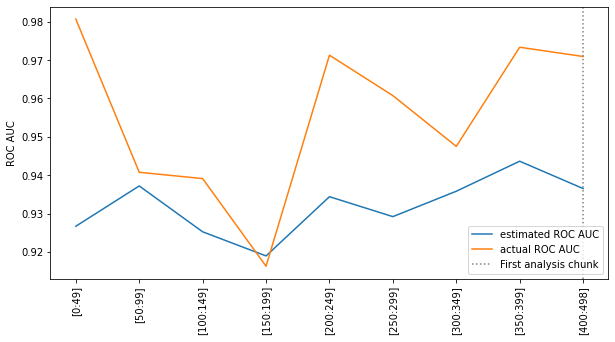

MSE: 0.0008543148507563525
Pearson r: (0.5364175187307703, 0.13652118482986525)


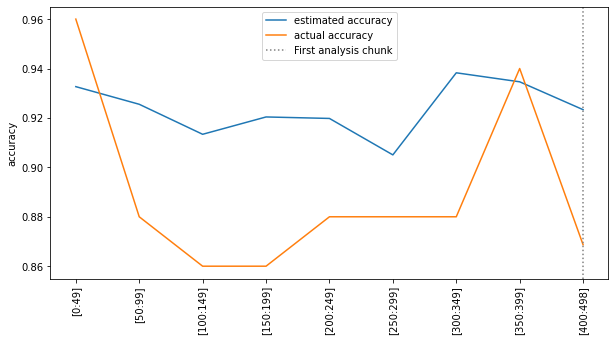

MSE: 0.001993451969085139
Pearson r: (0.5502534206043749, 0.12476712420507065)


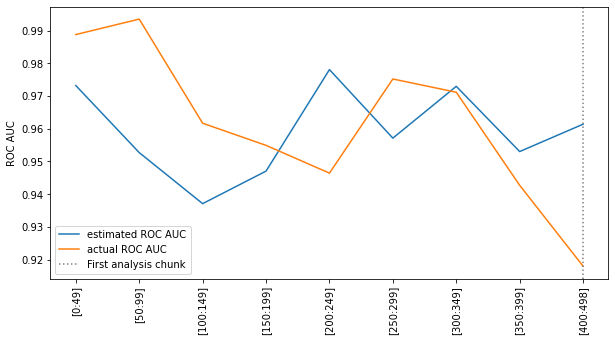

MSE: 0.0006550870537461981
Pearson r: (0.03518889905664092, 0.9283876940344788)


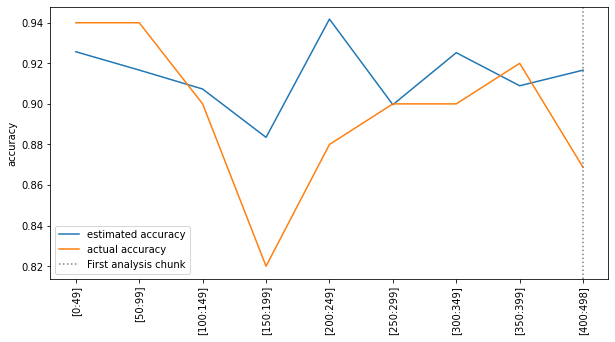

MSE: 0.0013012383096262926
Pearson r: (0.4506829809783457, 0.22342661725366783)


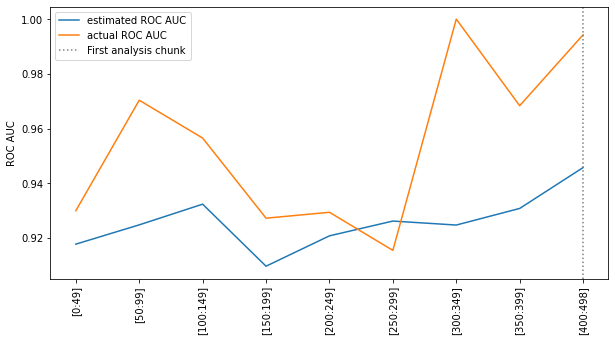

MSE: 0.001415165638637867
Pearson r: (0.6252675161363944, 0.07174428634274543)


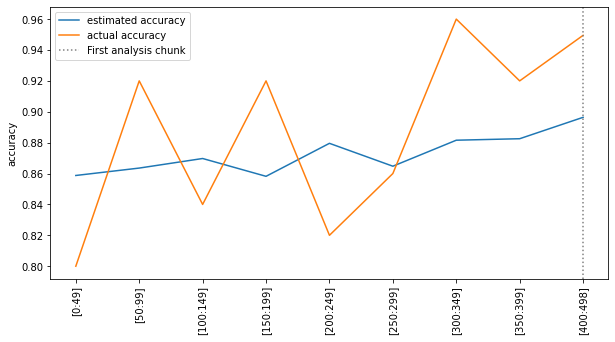

MSE: 0.002809293423710957
Pearson r: (0.4573538714903087, 0.21579559827637862)


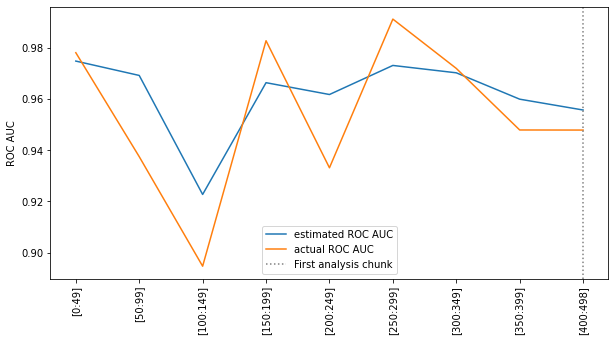

MSE: 0.00038029825590572467
Pearson r: (0.8447184299238797, 0.004159144996031048)


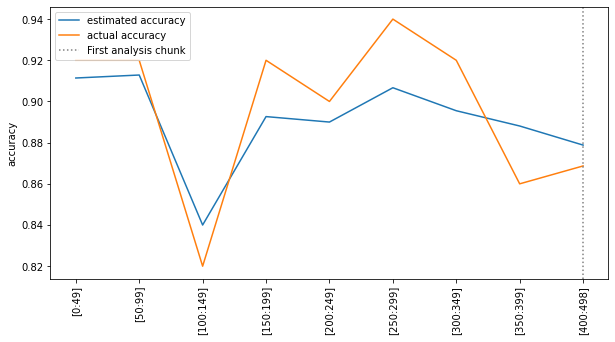

MSE: 0.0004417675780468947
Pearson r: (0.8958339861883288, 0.001083318030843302)
accuracy:  0.8925318761384334 - Prediction accuracy: 0.8985237577404661
f1:  0.8674157303370787 - Prediction  f1: 0.8737138907039034
precision:  0.9554455445544555 - Prediction  precision: 0.9720240227460938
recall:  0.7942386831275721 - Prediction  recall: 0.797348216674913
specificity:  0.9705882352941175 - Prediction  specificity: 0.981798590005582
roc_auc:  0.8824134592108448 - Prediction  roc_auc: 0.9618167837266111


In [30]:
#Get results in 10 fold - depth = 1
CBPE_accuracy_all1, CBPE_f1_all1, CBPE_precision_all1, CBPE_roc_auc_all1, CBPE_recall_all1, CBPE_specificity_all1 = ([] for i in range(6))
CBPE_pred_accuracy_all1, CBPE_pred_f1_all1, CBPE_pred_precision_all1, CBPE_pred_roc_auc_all1, CBPE_pred_recall_all1, CBPE_pred_specificity_all1 = ([] for i in range(6))

for i in range(10):
  #run the CRE algorithm
  idx = np.random.permutation(production_data.index)
  cbpe, CBPE_results,analysis_df, reference_df, CBPE_gt = run_CBPE(rfc1, X_test, y_test, production_data.reindex(idx), ground_truth.reindex(idx), send_gt=20, start_gt=50)
 
  #create plots
  get_roc_auc_plot(CBPE_gt,CBPE_results, analysis_df,reference_df)
  get_accuracy_plot(CBPE_gt,CBPE_results, analysis_df,reference_df)

  # Actual metrics
  analysis_targets = CBPE_gt[['id','class']]
  analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
  df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)

  gr = df_all['class'].to_numpy()
  CBPE_predictions = df_all['y_hat'].to_numpy().astype(int)
  CBPE_accuracy, CBPE_f1, CBPE_precision, CBPE_roc_auc, CBPE_recall, CBPE_specificity = get_scores(gr, CBPE_predictions)
  CBPE_accuracy_all1.append(CBPE_accuracy)
  CBPE_f1_all1.append(CBPE_f1)
  CBPE_precision_all1.append(CBPE_precision)
  CBPE_roc_auc_all1.append(CBPE_roc_auc)
  CBPE_recall_all1.append(CBPE_recall)
  CBPE_specificity_all1.append(CBPE_specificity)

  #CBPE metrics
  CBPE_pred_accuracy= CBPE_results['accuracy']['value']
  CBPE_pred_f1= CBPE_results['f1']['value']
  CBPE_pred_precision= CBPE_results['precision']['value']
  CBPE_pred_roc_auc= CBPE_results['roc_auc']['value']
  CBPE_pred_recall= CBPE_results['recall']['value']
  CBPE_pred_specificity= CBPE_results['specificity']['value']

  CBPE_pred_accuracy_all1.append(np.mean(CBPE_pred_accuracy))
  CBPE_pred_f1_all1.append(np.mean(CBPE_pred_f1))
  CBPE_pred_precision_all1.append(np.mean(CBPE_pred_precision))
  CBPE_pred_roc_auc_all1.append(np.mean(CBPE_pred_roc_auc))
  CBPE_pred_recall_all1.append(np.mean(CBPE_pred_recall))
  CBPE_pred_specificity_all1.append(np.mean(CBPE_pred_specificity))

# print results
print("accuracy: ", np.mean(CBPE_accuracy_all1), "- Prediction accuracy:", np.mean(CBPE_pred_accuracy_all1))
print("f1: ", np.mean(CBPE_f1_all1), "- Prediction  f1:", np.mean(CBPE_pred_f1_all1))
print("precision: ", np.mean(CBPE_precision_all1), "- Prediction  precision:", np.mean(CBPE_pred_precision_all1))
print("recall: ", np.mean(CBPE_recall_all1), "- Prediction  recall:", np.mean(CBPE_pred_recall_all1))
print("specificity: ", np.mean(CBPE_specificity_all1), "- Prediction  specificity:", np.mean(CBPE_pred_specificity_all1))
print("roc_auc: ", np.mean(CBPE_roc_auc_all1), "- Prediction  roc_auc:", np.mean(CBPE_pred_roc_auc_all1))


###CRE

##### Functions

In [31]:
# Place the predicted datapoints in the right bins
def card (P, B):
  datapoint_series = P.copy()
  initial_y_hat, starttime, b1 = datapoint_series[0]
  final_y_hat, endtime, bfinal = datapoint_series[-1]
  
  # time passed since datapoint first arrived
  time_passed = endtime-starttime
  timebloks = time_passed/B
  
  # make timebloks
  timeblok_array = []
  for i in range(B):
    timeblok_array.append(starttime + (i+1)*timebloks)

  # If the point does not have an bin, place it in the correct bin.
  for indx, instance in enumerate(datapoint_series):
    y_hat, time, B = instance
    if B == -1:
      for idx, i in enumerate(timeblok_array):
        if time <= i:
          datapoint_series[indx] = (y_hat, time, idx)
    else:
      continue
  return datapoint_series


##### Testing CRE

In [32]:
def run_CRE(model, model_depth, production_data, ground_truth):
  # testing CRE
  CRE_send_dist = get_send_distribution(send_gt = 20, start_gt = 50)

  # copy arrays and add a id column
  CRE_production_data = production_data.copy()
  CRE_ground_truth = ground_truth.copy()
  CRE_ground_truth_calc = ground_truth.copy()

  #lists to store initial predictions and final predictions
  CRE_predictions = pd.DataFrame(columns=['y_hat','id'])
  CRE_final_predictions = pd.DataFrame(columns=['y_hat','id'])
  B = 5
  K= 10

  #copy of the data
  new_data=X_train.copy()
  new_data['class']=y_train

  #Dictionary of waiting instances per index:
  #[x_k,?] = instance without ground truth
  #l = (number of labeled instances)
  L = {}

  #Dictionary of lists of prediction tuples
  P = {}

  #define start and endtime
  start_time = running_time(len(X_test))
  elapsed = 0

  # CRE based if pseudocode from the paper by Grzenda, Gomes and Bifet
  # https://link.springer.com/content/pdf/10.1007/s10618-019-00654-y.pdf?pdf=button
  for time, i in enumerate(CRE_send_dist):
    #Model used for prediction
    date_time = start_time + datetime.timedelta(minutes=elapsed)
    elapsed +=5

    # if i == 0 it is a datapoint
    if i == 0:
      # get the datapoint and drop it from the list
      x = CRE_production_data.head(1)
      CRE_production_data = CRE_production_data.tail(-1)
      x_id = str(x['id'].iloc[0])
    
      #get data for prediction
      prod_data = x.drop('id',axis=1)
    
      #predict point and add to prediction dataframe
      y_hat = model.predict(prod_data)
      new_row= pd.DataFrame({'y_hat': y_hat, 'id': x_id})
      CRE_predictions = pd.concat([new_row,CRE_predictions.loc[:]]).reset_index(drop=True)

      L[x_id]= [(x,0)]
      P[x_id] = [(y_hat[0], date_time, 0)]

    # if i ==1 it is the ground truth
    else:
      # get the datapoint and drop it from the list
      y = CRE_ground_truth.head(1)
      CRE_ground_truth = CRE_ground_truth.tail(-1)
      y_id = str(y['id'].iloc[0])

      #Add final prediction to P
      GT_data = y.drop(['id','class'],axis=1)
    
      #predict point and add to prediction dataframe
      y_hat = model.predict(GT_data)
      new_row= pd.DataFrame({'y_hat': y_hat, 'id': y_id})
      CRE_final_predictions = pd.concat([new_row,CRE_final_predictions.loc[:]]).reset_index(drop=True)
      P[y_id].append((y['class'].iloc[0], date_time, B+1))

      P[y_id] = card(P[y_id],B)

      new_row= {'variance': y["variance"], 'skewness': y["skewness"], 'curtosis': y["curtosis"], 'entropy': y["entropy"], 'class':y["class"]}
      new_data.append(new_row, ignore_index = True)
    
      # Remove from waiting dict
      popped = L.pop(y_id)
      for key in L:
        if (L[key][-1][1]%K) ==0:
          y_hat = model.predict(L[key][0][0].drop('id',axis=1))
          P[key].append((y_hat, date_time, -1))
        lst =list(L[key][-1])
        lst[1]=L[key][-1][1]+1
        L[key][-1]= tuple(lst)
    
      #train the model with the new datapoint added
    new_rfc = RandomForestClassifier(max_depth = model_depth)
    model = new_rfc.fit(new_data.drop('class',axis=1), new_data['class'])
  return CRE_predictions, CRE_final_predictions, CRE_ground_truth_calc

##### Evaluation of CRE

In [33]:
# Function to get the scores
def get_scores(actual, predictions):
  accuracy= accuracy_score(actual, predictions)
  f1= f1_score(actual, predictions)
  precision= precision_score(actual, predictions)
  roc_auc= roc_auc_score(actual, predictions)
  recall= recall_score(actual, predictions)
  # specificty is recall of negative class
  specificity= recall_score(actual, predictions, pos_label=0)
  return accuracy, f1, precision, roc_auc, recall, specificity


In [36]:
#Get results in 10 fold - depth = none
CRE_accuracy_all, CRE_f1_all, CRE_precision_all, CRE_roc_auc_all, CRE_recall_all, CRE_specificity_all = ([] for i in range(6))
CRE_final_accuracy_all, CRE_final_f1_all, CRE_final_precision_all, CRE_final_roc_auc_all, CRE_final_recall_all, CRE_final_specificity_all = ([] for i in range(6))

for i in range(10):
  #run the CRE algorithm
  idx = np.random.permutation(production_data.index)
  CRE_predictions, CRE_final_predictions, CRE_ground_truth_calc= run_CRE(rfc, None, production_data.reindex(idx), ground_truth.reindex(idx))
  
  # calculate metrics:

  # Sort the predictions by id such that it matches the ground truth dataframe
  CRE_predictions.id = CRE_predictions.id.astype(float)
  sorted_CRE_predictions = CRE_predictions.sort_values(by=['id'])

  CRE_final_predictions.id = CRE_final_predictions.id.astype(float)
  sorted_CRE_final_predictions = CRE_final_predictions.sort_values(by=['id'])

  CRE_ground_truth_calc.id = CRE_ground_truth_calc.id.astype(float)
  CRE_ground_truth_calc = CRE_ground_truth_calc.sort_values(by=['id'])

  # Get the array of ground truths and predictions. 
  gr = CRE_ground_truth_calc['class'].to_numpy()
  CRE_pred = sorted_CRE_predictions['y_hat'].to_numpy().astype(int)
  CRE_final_pred = sorted_CRE_final_predictions['y_hat'].to_numpy().astype(int)

  CRE_accuracy, CRE_f1, CRE_precision, CRE_roc_auc, CRE_recall, CRE_specificity = get_scores(gr, CRE_pred)
  CRE_accuracy_all.append(CRE_accuracy)
  CRE_f1_all.append(CRE_f1)
  CRE_precision_all.append(CRE_precision)
  CRE_roc_auc_all.append(CRE_roc_auc)
  CRE_recall_all.append(CRE_recall)
  CRE_specificity_all.append(CRE_specificity)

  CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_roc_auc, CRE_final_recall, CRE_final_specificity= get_scores(gr, CRE_final_pred)
  CRE_final_accuracy_all.append(CRE_final_accuracy)
  CRE_final_f1_all.append(CRE_final_f1)
  CRE_final_precision_all.append(CRE_final_precision)
  CRE_final_roc_auc_all.append(CRE_final_roc_auc)
  CRE_final_recall_all.append(CRE_final_recall)
  CRE_final_specificity_all.append(CRE_final_specificity)

# print results
print("Initial accuracy: ", np.mean(CRE_accuracy_all), "- Final accuracy:", np.mean(CRE_final_accuracy_all))
print("Initial f1: ", np.mean(CRE_f1_all), "- Final f1:", np.mean(CRE_final_f1_all))
print("Initial precision: ", np.mean(CRE_precision_all), "- Final precision:", np.mean(CRE_final_precision_all))
print("Initial recall: ", np.mean(CRE_recall_all), "- Final recall:", np.mean(CRE_final_recall_all))
print("Initial specificity: ", np.mean(CRE_specificity_all), "- Final specificity:", np.mean(CRE_final_specificity_all))
print("Initial roc_auc: ", np.mean(CRE_roc_auc_all), "- Final roc_auc:", np.mean(CRE_final_roc_auc_all))


Initial accuracy:  0.9958105646630235 - Final accuracy: 0.9952641165755919
Initial f1:  0.9952864541438562 - Final f1: 0.9946746403163329
Initial precision:  0.9914301626288262 - Final precision: 0.9902156688345072
Initial recall:  0.9991769547325102 - Final recall: 0.9991769547325102
Initial specificity:  0.9931372549019608 - Final specificity: 0.9921568627450981
Initial roc_auc:  0.9961571048172356 - Final roc_auc: 0.9956669087388041


In [37]:
#Get results in 10 fold - depth = 1
CRE_accuracy_all1, CRE_f1_all1, CRE_precision_all1, CRE_roc_auc_all1, CRE_recall_all1, CRE_specificity_all1 = ([] for i in range(6))
CRE_final_accuracy_all1, CRE_final_f1_all1, CRE_final_precision_all1, CRE_final_roc_auc_all1, CRE_final_recall_all1, CRE_final_specificity_all1 = ([] for i in range(6))

for i in range(10):
  #run the CRE algorithm
  idx = np.random.permutation(production_data.index)
  CRE_predictions, CRE_final_predictions, CRE_ground_truth_calc= run_CRE(rfc1, 1, production_data.reindex(idx), ground_truth.reindex(idx))
  
  # calculate metrics:

  # Sort the predictions by id such that it matches the ground truth dataframe
  CRE_predictions.id = CRE_predictions.id.astype(float)
  sorted_CRE_predictions = CRE_predictions.sort_values(by=['id'])

  CRE_final_predictions.id = CRE_final_predictions.id.astype(float)
  sorted_CRE_final_predictions = CRE_final_predictions.sort_values(by=['id'])

  CRE_ground_truth_calc.id = CRE_ground_truth_calc.id.astype(float)
  CRE_ground_truth_calc = CRE_ground_truth_calc.sort_values(by=['id'])

  # Get the array of ground truths and predictions. 
  gr = CRE_ground_truth_calc['class'].to_numpy()
  CRE_pred = sorted_CRE_predictions['y_hat'].to_numpy().astype(int)
  CRE_final_pred = sorted_CRE_final_predictions['y_hat'].to_numpy().astype(int)

  CRE_accuracy, CRE_f1, CRE_precision, CRE_roc_auc, CRE_recall, CRE_specificity = get_scores(gr, CRE_pred)
  CRE_accuracy_all1.append(CRE_accuracy)
  CRE_f1_all1.append(CRE_f1)
  CRE_precision_all1.append(CRE_precision)
  CRE_roc_auc_all1.append(CRE_roc_auc)
  CRE_recall_all1.append(CRE_recall)
  CRE_specificity_all1.append(CRE_specificity)

  CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_roc_auc, CRE_final_recall, CRE_final_specificity= get_scores(gr, CRE_final_pred)
  CRE_final_accuracy_all1.append(CRE_final_accuracy)
  CRE_final_f1_all1.append(CRE_final_f1)
  CRE_final_precision_all1.append(CRE_final_precision)
  CRE_final_roc_auc_all1.append(CRE_final_roc_auc)
  CRE_final_recall_all1.append(CRE_final_recall)
  CRE_final_specificity_all1.append(CRE_final_specificity)

# print results
print("Initial accuracy: ", np.mean(CRE_accuracy_all1), "- Final accuracy:", np.mean(CRE_final_accuracy_all1))
print("Initial f1: ", np.mean(CRE_f1_all1), "- Final f1:", np.mean(CRE_final_f1_all1))
print("Initial precision: ", np.mean(CRE_precision_all1), "- Final precision:", np.mean(CRE_final_precision_all1))
print("Initial recall: ", np.mean(CRE_recall_all1), "- Final recall:", np.mean(CRE_final_recall_all1))
print("Initial specificity: ", np.mean(CRE_specificity_all1), "- Final specificity:", np.mean(CRE_final_specificity_all1))
print("Initial roc_auc: ", np.mean(CRE_roc_auc_all1), "- Final roc_auc:", np.mean(CRE_final_roc_auc_all1))

Initial accuracy:  0.8892531876138433 - Final accuracy: 0.8897996357012751
Initial f1:  0.8701239948004307 - Final f1: 0.8711512258050599
Initial precision:  0.9045888021545242 - Final precision: 0.9029629678829071
Initial recall:  0.8382716049382715 - Final recall: 0.8415637860082305
Initial specificity:  0.9297385620915033 - Final specificity: 0.9281045751633987
Initial roc_auc:  0.8840050835148874 - Final roc_auc: 0.8848341805858146


In [38]:
#Get results in 10 fold - depth = 3
CRE_accuracy_all3, CRE_f1_all3, CRE_precision_all3, CRE_roc_auc_all3, CRE_recall_all3, CRE_specificity_all3 = ([] for i in range(6))
CRE_final_accuracy_all3, CRE_final_f1_all3, CRE_final_precision_all3, CRE_final_roc_auc_all3, CRE_final_recall_all3, CRE_final_specificity_all3 = ([] for i in range(6))

for i in range(10):
  #run the CRE algorithm
  idx = np.random.permutation(production_data.index)
  CRE_predictions, CRE_final_predictions, CRE_ground_truth_calc= run_CRE(rfc3, 3, production_data.reindex(idx), ground_truth.reindex(idx))
  
  # calculate metrics:

  # Sort the predictions by id such that it matches the ground truth dataframe
  CRE_predictions.id = CRE_predictions.id.astype(float)
  sorted_CRE_predictions = CRE_predictions.sort_values(by=['id'])

  CRE_final_predictions.id = CRE_final_predictions.id.astype(float)
  sorted_CRE_final_predictions = CRE_final_predictions.sort_values(by=['id'])
  
  CRE_ground_truth_calc.id = CRE_ground_truth_calc.id.astype(float)
  CRE_ground_truth_calc = CRE_ground_truth_calc.sort_values(by=['id'])

  # Get the array of ground truths and predictions. 
  gr = CRE_ground_truth_calc['class'].to_numpy()
  CRE_pred = sorted_CRE_predictions['y_hat'].to_numpy().astype(int)
  CRE_final_pred = sorted_CRE_final_predictions['y_hat'].to_numpy().astype(int)

  CRE_accuracy, CRE_f1, CRE_precision, CRE_roc_auc, CRE_recall, CRE_specificity = get_scores(gr, CRE_pred)
  CRE_accuracy_all3.append(CRE_accuracy)
  CRE_f1_all3.append(CRE_f1)
  CRE_precision_all3.append(CRE_precision)
  CRE_roc_auc_all3.append(CRE_roc_auc)
  CRE_recall_all3.append(CRE_recall)
  CRE_specificity_all3.append(CRE_specificity)

  CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_roc_auc, CRE_final_recall, CRE_final_specificity= get_scores(gr, CRE_final_pred)
  CRE_final_accuracy_all3.append(CRE_final_accuracy)
  CRE_final_f1_all3.append(CRE_final_f1)
  CRE_final_precision_all3.append(CRE_final_precision)
  CRE_final_roc_auc_all3.append(CRE_final_roc_auc)
  CRE_final_recall_all3.append(CRE_final_recall)
  CRE_final_specificity_all3.append(CRE_final_specificity)

# print results
print("Initial accuracy: ", np.mean(CRE_accuracy_all3), "- Final accuracy:", np.mean(CRE_final_accuracy_all3))
print("Initial f1: ", np.mean(CRE_f1_all3), "- Final f1:", np.mean(CRE_final_f1_all3))
print("Initial precision: ", np.mean(CRE_precision_all3), "- Final precision:", np.mean(CRE_final_precision_all3))
print("Initial recall: ", np.mean(CRE_recall_all3), "- Final recall:", np.mean(CRE_final_recall_all3))
print("Initial specificity: ", np.mean(CRE_specificity_all3), "- Final specificity:", np.mean(CRE_final_specificity_all3))
print("Initial roc_auc: ", np.mean(CRE_roc_auc_all3), "- Final roc_auc:", np.mean(CRE_final_roc_auc_all3))

Initial accuracy:  0.9661202185792351 - Final accuracy: 0.9675774134790529
Initial f1:  0.9618531391516036 - Final f1: 0.9635513135175152
Initial precision:  0.9587147422042352 - Final precision: 0.9588431176319029
Initial recall:  0.9650205761316872 - Final recall: 0.9683127572016461
Initial specificity:  0.9669934640522875 - Final specificity: 0.9669934640522875
Initial roc_auc:  0.9660070200919874 - Final roc_auc: 0.9676531106269668
